In [25]:
from pathlib import Path
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import soundfile as sf
import pandas as pd

import os 
import itertools
import re
import math
import csv
import random
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from scipy.fftpack import fftn, ifftn, fft, ifft
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import signal
import pickle
from sklearn.externals import joblib
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import ShuffleSplit
import warnings

warnings.filterwarnings('ignore') 
df = pd.read_csv("features/Features10too200hz.csv")

#df = pd.read_csv("features/unfilteredFeatures.csv")

#df = pd.read_csv("Features_all_no_audible.csv")
#df = df[(df.modeID != 'audible')]
#df= df[df.sessionID == 4002 ]
df

,channel_1_mav,channel_1_mav2,channel_1_rms,channel_1_iav,channel_1_ssi,channel_1_var,channel_1_wl,channel_1_iemg,channel_1_aac,channel_1_zc,...,channel_6_aac,channel_6_zc,channel_6_ssc,channel_6_wamp,channel_6_medf,channel_6_meanf,userID,sessionID,uttID,modeID
0,0.034982,0.033315,0.047836,117.153433,7.663511,0.002288,131.601251,117.153433,0.039296,1239,...,0.043452,1150,1395,2,94.594595,111.041462,1,1001,10010001,audible
1,0.028157,0.026247,0.040353,63.465079,3.670272,0.001628,71.151924,63.465079,0.031567,861,...,0.032478,749,930,1,100.446429,111.273560,1,1001,10010002,audible
2,0.035103,0.034455,0.049304,142.411421,9.862262,0.002431,160.962810,142.411421,0.039675,1552,...,0.050138,1382,1683,7,95.049505,109.108856,1,1001,10010003,audible
3,0.032311,0.032380,0.044599,134.576651,8.284614,0.001989,151.073407,134.576651,0.036272,1551,...,0.054896,1449,1761,9,91.807229,109.532973,1,1001,10010004,audible
4,0.030766,0.030669,0.044142,144.633076,9.159818,0.001948,161.532869,144.633076,0.034361,1743,...,0.050953,1611,1922,6,97.867804,112.357899,1,1001,10010005,audible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,0.024542,0.023903,0.041126,57.330769,3.950974,0.001691,49.749426,57.330769,0.021297,674,...,0.005497,710,948,0,71.120690,99.526715,8,8019,80190246,whisper
4796,0.016662,0.016446,0.024829,31.741925,1.174369,0.000616,28.414596,31.741925,0.014916,542,...,0.004438,577,787,0,73.015873,99.631579,8,8019,80190247,whisper
4797,0.019216,0.018149,0.027342,43.312481,1.685064,0.000748,38.049582,43.312481,0.016881,634,...,0.004820,704,953,0,85.714286,107.323391,8,8019,80190248,whisper
4798,0.015547,0.014571,0.022414,26.616147,0.860052,0.000502,24.287830,26.616147,0.014187,521,...,0.004274,522,712,0,72.352941,99.541204,8,8019,80190249,whisper


In [26]:
def split_data_per_session(session_id):
    temp_df = df[(df.sessionID == session_id)]
    data = temp_df.copy()
    data = shuffle(data)
    y = data['modeID']
    data.drop(labels=['userID','uttID', 'sessionID','modeID'], axis=1, inplace=True)
    return train_test_split(data, y, test_size=0.2)

def split_data_session(train_user_ids,test_user_ids):
    temp_df = df
    data = temp_df.copy()
    train_df = data.loc[data['sessionID'].isin(train_user_ids)]
    test_df = data.loc[data['sessionID'].isin(test_user_ids)]
    X_train = train_df.copy()
    X_test = test_df.copy()
    y_train = X_train['modeID']
    y_test = X_test['modeID']
    X_train.drop(labels=['userID','uttID', 'sessionID','modeID'], axis=1, inplace=True)
    X_test.drop(labels=['userID','uttID', 'sessionID','modeID'], axis=1, inplace=True)
    return X_train, X_test, y_train, y_test 

def split_data_utterance(train_user_ids,test_user_ids):
    temp_df = df
    data = temp_df.copy()
    train_df = data.loc[data['userID'].isin(train_user_ids)]
    test_df = data.loc[data['userID'].isin(test_user_ids)]
    X_train = train_df.copy()
    X_test = test_df.copy()
    y_train = X_train['modeID']
    y_test = X_test['modeID']
    X_train.drop(labels=['userID','uttID', 'sessionID','modeID'], axis=1, inplace=True)
    X_test.drop(labels=['userID','uttID', 'sessionID','modeID'], axis=1, inplace=True)
    return X_train, X_test, y_train, y_test 

def split_data(train_user_ids,test_user_ids):
    temp_df = df
    data = temp_df.copy()
    train_df = data.loc[data['userID'].isin(train_user_ids)]
    test_df = data.loc[data['userID'].isin(test_user_ids)]
    X_train = train_df.copy()
    X_test = test_df.copy()
    y_train = X_train['modeID']
    y_test = X_test['modeID']
    X_train.drop(labels=['userID','uttID', 'sessionID','modeID'], axis=1, inplace=True)
    X_test.drop(labels=['userID','uttID', 'sessionID','modeID'], axis=1, inplace=True)
    return X_train, X_test, y_train, y_test 

In [27]:
def lda_user1():
    train_ids = [2,3,4,5,6,7,8]
    test_ids = [1]
    X_train, X_test, y_train, y_test = split_data(train_ids,test_ids)
    k_clf = LinearDiscriminantAnalysis()
    k_clf.fit(X_train, y_train)
    score = k_clf.score(X_test, y_test)
    print("Accuracy for user1  is "+str(score))
    #plot_confusion_matrix(k_clf, X_test, y_test,normalize='true')  # doctest: +SKIP
    #plt.title("User" + str(test_ids[0]))
    #plt.savefig(os.path.join("User" + str(test_ids[0])+".png"), dpi=600, format='png', bbox_inches='tight')
    #plt.show()
    b=k_clf.predict(X_test)
    return b,y_test    

def lda_user2():
    train_ids = [1,3,4,5,6,8]
    test_ids = [2]
    X_train, X_test, y_train, y_test = split_data(train_ids,test_ids)
    k_clf = LinearDiscriminantAnalysis()
    k_clf.fit(X_train, y_train)
    score = k_clf.score(X_test, y_test)
    print("Accuracy for user2  is "+str(score))
    a=np.unique(k_clf.predict(X_test))
    #plot_confusion_matrix(k_clf, X_test, y_test,normalize='true')  # doctest: +SKIP
    #plt.title("User" + str(test_ids[0]))
    #plt.savefig(os.path.join("User" + str(test_ids[0])+".png"), dpi=600, format='png', bbox_inches='tight')
    #plt.show()
    b=k_clf.predict(X_test)
    return b,y_test   
    
def lda_user3():
    train_ids = [1,2,4,5,6,7,8]
    test_ids = [3]
    X_train, X_test, y_train, y_test = split_data(train_ids,test_ids)
    k_clf = LinearDiscriminantAnalysis()
    k_clf.fit(X_train, y_train)
    score = k_clf.score(X_test, y_test)
    print("Accuracy for user3 is "+str(score))
    a=np.unique(k_clf.predict(X_test))
    #plot_confusion_matrix(k_clf, X_test, y_test,normalize='true')  # doctest: +SKIP
    #plt.title("User" + str(test_ids[0]))
    #plt.savefig(os.path.join("User" + str(test_ids[0])+".png"), dpi=600, format='png', bbox_inches='tight')
    #plt.show()
    b=k_clf.predict(X_test)
    return b,y_test 
    
def lda_user4():
    train_ids = [1,2,3,5,6,7,8]
    test_ids = [4]
    X_train, X_test, y_train, y_test = split_data(train_ids,test_ids)
    k_clf = LinearDiscriminantAnalysis()
    k_clf.fit(X_train, y_train)
    score = k_clf.score(X_test, y_test)
    print("Accuracy for user4 is "+str(score))
    a=np.unique(k_clf.predict(X_test))
    #plot_confusion_matrix(k_clf, X_test, y_test,normalize='true')  # doctest: +SKIP
    #plt.title("User" + str(test_ids[0]))
    #plt.savefig(os.path.join("User" + str(test_ids[0])+".png"), dpi=600, format='png', bbox_inches='tight')
    #plt.show()
    b=k_clf.predict(X_test)
    return b,y_test     
        
def lda_user5():
    train_ids = [1,2,3,4,6,7,8]
    test_ids = [5]
    X_train, X_test, y_train, y_test = split_data(train_ids,test_ids)
    k_clf = LinearDiscriminantAnalysis()
    k_clf.fit(X_train, y_train)
    score = k_clf.score(X_test, y_test)
    print("Accuracy for user5 is "+str(score))
    a=np.unique(k_clf.predict(X_test))
    #plot_confusion_matrix(k_clf, X_test, y_test,normalize='true')  # doctest: +SKIP
    #plt.title("User" + str(test_ids[0]))
    #plt.savefig(os.path.join("User" + str(test_ids[0])+".png"), dpi=600, format='png', bbox_inches='tight')
    #plt.show()
    b=k_clf.predict(X_test)
    return b,y_test   
    
def lda_user6():
    train_ids = [1,2,3,4,5,7,8]
    test_ids = [6]
    X_train, X_test, y_train, y_test = split_data(train_ids,test_ids)
    k_clf = LinearDiscriminantAnalysis()
    k_clf.fit(X_train, y_train)
    score = k_clf.score(X_test, y_test)
    print("Accuracy for user6 is "+str(score))
    a=np.unique(k_clf.predict(X_test))
    #plot_confusion_matrix(k_clf, X_test, y_test,normalize='true')  # doctest: +SKIP
    #plt.title("User" + str(test_ids[0]))
    #plt.savefig(os.path.join("User" + str(test_ids[0])+".png"), dpi=600, format='png', bbox_inches='tight')
    #plt.show()
    b=k_clf.predict(X_test)
    return b,y_test   
    
def lda_user7():
    train_ids = [1,2,3,4,5,6,8]
    test_ids = [7]
    X_train, X_test, y_train, y_test = split_data(train_ids,test_ids)
    k_clf = LinearDiscriminantAnalysis()
    k_clf.fit(X_train, y_train)
    score = k_clf.score(X_test, y_test)
    print("Accuracy for user7 is "+str(score))
    a=np.unique(k_clf.predict(X_test))
    #a=((np.append(a, )))
    #plot_confusion_matrix(k_clf, X_test, y_test,normalize='true')  # doctest: +SKIP
    #plt.title("User" + str(test_ids[0]))
    #plt.savefig(os.path.join("User" + str(test_ids[0])+".png"), dpi=600, format='png', bbox_inches='tight')
    #plt.show()
    b=k_clf.predict(X_test)
    return b,y_test     
    
def lda_user8():
    train_ids = [1,2,3,4,5,6,7]
    test_ids = [8]
    X_train, X_test, y_train, y_test = split_data(train_ids,test_ids)
    k_clf = LinearDiscriminantAnalysis()
    k_clf.fit(X_train, y_train)
    score = k_clf.score(X_test, y_test)
    print("Accuracy for user8 is "+str(score))
    a=np.unique(k_clf.predict(X_test))
    #plot_confusion_matrix(k_clf, X_test, y_test,normalize='true')  # doctest: +SKIP
    #plt.title("User" + str(test_ids[0]))
    #plt.savefig(os.path.join("User" + str(test_ids[0])+".png"), dpi=600, format='png', bbox_inches='tight')
    #plt.show()
    b=k_clf.predict(X_test)
    return b,y_test  

In [29]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.externals import joblib
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
def lda_users():
    y_pred = []
    y_actu = []
    labels = ['audible', 'silent','whisper']
    y_p,y_a = lda_user1()
    y_pred =np.concatenate((y_pred, y_p))
    y_actu =np.concatenate((y_actu, y_a))
    b = lda_user2()
    y_p,y_a = lda_user2()
    y_pred =np.concatenate((y_pred, y_p))
    y_actu =np.concatenate((y_actu, y_a))
    c = lda_user3()
    y_p,y_a = lda_user3()
    y_pred =np.concatenate((y_pred, y_p))
    y_actu =np.concatenate((y_actu, y_a))
    d = lda_user4()
    y_p,y_a = lda_user4()
    y_pred =np.concatenate((y_pred, y_p))
    y_actu =np.concatenate((y_actu, y_a))
    e = lda_user5()
    y_p,y_a = lda_user5()
    y_pred =np.concatenate((y_pred, y_p))
    y_actu =np.concatenate((y_actu, y_a))
    f = lda_user6()
    y_p,y_a = lda_user6()
    y_pred =np.concatenate((y_pred, y_p))
    y_actu =np.concatenate((y_actu, y_a))
    g = lda_user7()
    y_p,y_a = lda_user7()
    y_pred =np.concatenate((y_pred, y_p))
    y_actu =np.concatenate((y_actu, y_a))
    h = lda_user8()
    y_p,y_a = lda_user8()
    y_pred =np.concatenate((y_pred, y_p))
    y_actu =np.concatenate((y_actu, y_a))
    #scores = np.array([a,b,c,d,e,f,g,h])
    a = confusion_matrix(y_actu, y_pred, labels=labels,normalize='true')
    plt.figure()
    cm_display = ConfusionMatrixDisplay(a,display_labels=labels).plot()
    plt.title("Speechmode")
    plt.savefig(os.path.join("AllUserModeConfMat.png"), dpi=600, format='png', bbox_inches='tight')
    #print("Durchschnitt: ")
    #print (scores.mean())
    #print(scores.std())

Accuracy for user1  is 0.4666666666666667
Accuracy for user2  is 0.33511111111111114
Accuracy for user2  is 0.33511111111111114
Accuracy for user3 is 0.42
Accuracy for user3 is 0.42
Accuracy for user4 is 0.4633333333333333
Accuracy for user4 is 0.4633333333333333
Accuracy for user5 is 0.58
Accuracy for user5 is 0.58
Accuracy for user6 is 0.66
Accuracy for user6 is 0.66
Accuracy for user7 is 0.6066666666666667
Accuracy for user7 is 0.6066666666666667
Accuracy for user8 is 0.3961904761904762
Accuracy for user8 is 0.3961904761904762


<Figure size 432x288 with 0 Axes>

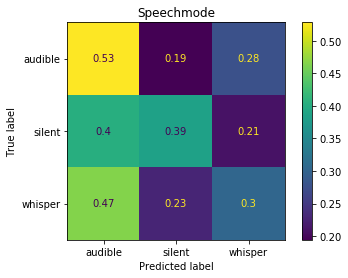

In [30]:
lda_users()

In [5]:
def lda_user8():
    train_ids = [1,2,3,4,5,6,8]
    test_ids = [7]
    X_train, X_test, y_train, y_test = split_data(train_ids,test_ids)
    k_clf = LinearDiscriminantAnalysis()
    k_clf.fit(X_train, y_train)
    score = k_clf.score(X_test, y_test)
    print("Accuracy for user8 is "+str(score))
    a=np.unique(k_clf.predict(X_test))
    b=k_clf.predict(X_test)
    print (b)
    print(y_test)
    #plot_confusion_matrix(k_clf, X_test, y_test,normalize='true')  # doctest: +SKIP
    #plt.title("User" + str(test_ids[0]))
    #plt.savefig(os.path.join("User" + str(test_ids[0])+"_unf.png"), dpi=600, format='png', bbox_inches='tight')
    #plt.show()
    return a 

In [6]:
lda_user8()

Accuracy for user8 is 0.48
['silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent' 'silent'
 'silent' 'silent' 'sile

array(['audible', 'silent'], dtype='<U7')